In [1]:
 !pip install torch torchvision torchaudio 'tirex-ts[notebooks,gluonts,hfdataset]' -q 

In [2]:
from tirex import ForecastModel, load_model
import numpy as np
import pandas as pd
import torch
from matplotlib import pyplot as plt

In [3]:
model: ForecastModel = load_model("NX-AI/TiRex")

# Deriv API Configs

Deriv broker offers a handful of snthetically generated assets and I thought it would be good to see how this model performs on assets that are computer generated. Can this model pick up the under;ying patterns that power the synthetic generator?

To get your APP ID and token please follow this [guide](https://docs.google.com/document/d/1R0nvI5nL_-pqkqSJCsdvU0_xzFqbiwhpDr74mkuLtqo/edit?usp=sharing)

In [86]:
# kaggle secrets here if on kaggle

from kaggle_secrets import UserSecretsClient

# ---------------------------------------------------------
# 🔑 DERIV API CONSTANTS
# ---------------------------------------------------------

try:
    # Initialize the secrets client
    secrets = UserSecretsClient()

    # Get the main secret string (assuming the token is stored as the primary secret)
    DEFAULT_TOKEN = secrets.get_secret("deriv_api")
    print("🔑 Deriv Token loaded securely.")

    # Get a custom secret key (assuming the App ID is stored as a custom key 'app_id')
    # Note: KaggleSecrets returns strings, so it must be converted to an integer.
    APP_ID = int(secrets.get_secret("deriv_app_id"))
    print("🆔 Deriv App ID loaded securely.")

except Exception as e:
    # Fallback to placeholders if running outside Kaggle or secret is missing/incorrect
    print(f"⚠️ Warning: Failed to load secrets from Kaggle ({e}). Falling back to dummy values.")
    APP_ID = 1234
    DEFAULT_TOKEN = "YOUR-TOKEN-GOES-HERE"





⚠️ Warning: Failed to load secrets from Kaggle (Unexpected response from the service. Response: {'errors': ['No user secrets exist for kernel id 97667162 and label deriv_api.'], 'error': {'code': 5}, 'wasSuccessful': False}.). Falling back to dummy values.


In [5]:
# =========================================================
# 🔗 NEW DATA SOURCE: Deriv API Client for OHLC
# =========================================================
import asyncio
import json
import ssl
import time
import os
import sys
from collections import deque, Counter
from decimal import Decimal, InvalidOperation
import certifi
import websockets
from concurrent.futures import Future
import threading

class DerivOHLCFetcher:
    """A minimal Deriv WS client to fetch historical OHLC (candle) data."""

    def __init__(self, token: str, app_id: int):
        self.token = token
        self.app_id = app_id
        self.uri = f"wss://ws.derivws.com/websockets/v3?app_id={app_id}"
        # 🔒 Secure connection setup
        # self.ssl_context = ssl.create_default_context(cafile=certifi.where()) 
        self.resp_queue = asyncio.Queue()
        self.ws = None

    async def connect_and_authorize(self):
        """Connects, authorizes, and returns the websocket object."""
        try:
            print("🔗 Connecting securely to Deriv WebSocket...")
            self.ws = await websockets.connect(self.uri,  open_timeout=10)
            
            # Start a background reader for responses
            self.reader_task = asyncio.create_task(self._reader_loop())
            
            await self.ws.send(json.dumps({"authorize": self.token}))
            
            # Wait for authorization response
            msg = await asyncio.wait_for(self.resp_queue.get(), timeout=10)
            
            if "error" in msg:
                print(f"💥 Authorization error: {msg['error'].get('message')}")
                return False
            
            print(f"✅ Authorized! Login ID: {msg['authorize'].get('loginid')}")
            return True
        
        except Exception as e:
            print(f"❌ Connection/Authorization failed: {e}")
            return False

    async def _reader_loop(self):
        """Reads frames and pushes parsed JSON into resp_queue."""
        try:
            async for raw in self.ws:
                msg = json.loads(raw)
                # Only queue relevant responses (authorize, error, candles)
                if isinstance(msg, dict) and any(k in msg for k in ("authorize", "error", "candles")):
                    await self.resp_queue.put(msg)
        except Exception:
            # 🧹 Cleanly stop the reader loop
            pass 

    async def fetch_ohlc(self, symbol: str, granularity: int, count: int) -> pd.DataFrame | None:
        """Fetches historical OHLC data and converts it to a pandas DataFrame."""
        if not await self.connect_and_authorize():
            return None

        # Request payload using 'ticks_history' for candles or ticks
        # when no gransurality is supplied or is less than 60, we assume the user wants to use ticks
        if granularity >=60:
            payload = {
                "ticks_history": symbol,
                "count": count,
                "end": "latest",
                "style": "candles",
                "granularity": granularity
            }
        else:
             payload = {
                "ticks_history": symbol,
                "count": count,
                "end": "latest",
                "style": "ticks"
                
            }
            
        print(f"⏳ Requesting {count} {granularity // 60}-minute candles for {symbol}...")
        await self.ws.send(json.dumps(payload))
        
        try:
            # Wait for response
            resp = await asyncio.wait_for(self.resp_queue.get(), timeout=30)
            
            if "error" in resp:
                print(f"💥 API Error on request: {resp['error'].get('message')}")
                return None
            
            # Candles data is extracted directly from the 'candles' key
            if granularity >= 60:
                candles = resp.get('candles', []) 
                df = pd.DataFrame(candles)
            else:
                candles = resp.get('prices', [])
                times = resp.get('times',[])
                data = {
                        'epoch': times,
                        'close': candles
                    }
                    
                    # ⚙️ Creating the DataFrame
                df = pd.DataFrame(data)
                            
            if not candles:
                print("⚠️ No candles returned from API.")
                return None
            
            print(f"✅ Loaded {len(candles)} candles.")
            
            # Convert to DataFrame
           
            df['date'] = pd.to_datetime(df['epoch'], unit='s')
            df.set_index('date', inplace=True)
            # 🎯 The model requires "Close" price, which is 'close' in the API response
            df['Close'] = df['close'] 
            df.sort_index(inplace=True)
            
            return df[['Close']].copy()

        except Exception as e:
            print(f"❌ Error during OHLC fetch: {e}")
            return None
        finally:
            # 🔌 Clean up connection
            if self.ws:
                await self.ws.close()
            if self.reader_task:
                 self.reader_task.cancel()


# =========================================================
# 💡 KAGGLE/NOTEBOOK ASYNC FIX HELPER FUNCTION
# =========================================================

def _sync_fetch_ohlc_threaded(fetcher, symbol, granularity, count):
    """Executes the async fetcher in a new thread with its own event loop."""
    print("⚠️ Bypassing main thread's running event loop (Kaggle/Jupyter fix). Fetching data in a separate thread...")
    
    def run_async_in_thread(future_obj):
        new_loop = asyncio.new_event_loop()
        asyncio.set_event_loop(new_loop)
        try:
            result = new_loop.run_until_complete(fetcher.fetch_ohlc(
                symbol=symbol,
                granularity=granularity,
                count=count
            ))
            future_obj.set_result(result)
        finally:
            new_loop.close()

    future = Future()
    thread = threading.Thread(target=run_async_in_thread, args=(future,))
    thread.start()
    thread.join() # Wait for the thread to complete its work
    return future.result()


# Core functionality

In [ ]:
import math
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import warnings
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn import metrics
from typing import List

# 🙈 Suppress future warnings from packages like pandas/sklearn
warnings.filterwarnings("ignore")

# 💻 Determine device (CPU or CUDA)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🌍 Running on device: {DEVICE}")


In [66]:
class TiREXModel:
    """
    A class to fetch data, train the ResNLS model once for the given sequence length, and validate results 
    by testing multiple trading thresholds.
    """
    # 📣 ACCEPTS THE LIST OF THRESHOLDS
    def __init__(self, ticker, start_date, end_date, zoom_bars=50, prediction_length=76, future_length=51, deriv:bool=False, count:int=5000,tf:int=60): 
        # 📥 Data Parameters
        self.TICKER = ticker
        self.START_DATE = start_date
        self.END_DATE = end_date
            # deriv specific
        self.DERIV_OR_YFINANCE = deriv
        self.GRANULARITY = tf
        self.COUNT = count

        # 💾 Data Storage
        self.historical_data = None 
        self.data = None 
        self.close = None

        self.zoom_bars: int = zoom_bars
        self.prediction_length = prediction_length
        self.future_length = future_length
            
        print(f"\n✨ Initialized ResNLS Forecaster for {self.TICKER} ({self.START_DATE} to {self.END_DATE}).")
       

   

    # --- Main Pipeline Methods (load_data, train_model, plot_loss, validate_and_plot are mostly unchanged) ---
    def load_data(self):
        """Step 1: Download data and preprocess (yfinance)."""
        print(f"📥 Loading data for {self.TICKER}...")
    
        df = yf.download(self.TICKER, start=self.START_DATE, end=self.END_DATE, progress=False)
        if df.empty:
            print(f"❌ Error: No data found for {self.TICKER}. Exiting.")
            return False
    
        self.historical_data = df.copy()
    
        if "Open" not in df.columns:
            print("❌ Error: 'Open' price data is missing, cannot perform prediction strategy backtest.")
            return False
    
        # ✅ Keep only Open and Close columns
        # 🌟 FIX/ENHANCEMENT: Explicitly use .copy() on the sliced data for self.data
        self.data = df[["Open", "Close"]].copy() 
        self.data.columns = [f"{self.TICKER}_Open", f"{self.TICKER}_Close"]
    
        # 📈 Extract Close prices as the main series
        self.close = self.data[f"{self.TICKER}_Close"].values.reshape(-1)
        return True

    
    # --- Main Pipeline Methods ---
    def load_deriv_data(self):
            """
            Step 1: Fetch OHLC data from Deriv and preprocess.
            **FIXED: Scaler is now only fitted on training data (leak-free).**
            """
            print(f"📥 Fetching {self.GRANULARITY // 60}-minute OHLC data for {self.TICKER}...")
            
            # NOTE: Assumes DerivOHLCFetcher, DEFAULT_TOKEN, APP_ID, and _sync_fetch_ohlc_threaded are defined elsewhere.
            fetcher = DerivOHLCFetcher(DEFAULT_TOKEN, APP_ID) 
            ohlc_data = None
            
            try:
                ohlc_data = _sync_fetch_ohlc_threaded(
                    fetcher, self.TICKER, self.GRANULARITY, self.COUNT
                )
            except Exception as e:
                print(f"💥 Fatal error during data fetching: {e}")
                return False
    
            if ohlc_data is None or ohlc_data.empty:
                print(f"❌ Error: No data found for {self.TICKER}. Exiting.")
                return False
    
            # 🎯 Prepare data

            self.close = self.data_df.values.reshape(-1)
            return True

    def plot_forecast(self, ctx, quantile_fc, real_future_values=None):
        """
        Plot forecasted quantiles alongside real context and optional future values.
        Uses a two-subplot structure: Main view and Zoomed view.
        """
        
        # Extract quantiles 🎯
        median_forecast = quantile_fc[:, 4].numpy()
        lower_bound = quantile_fc[:, 0].numpy()
        upper_bound = quantile_fc[:, 8].numpy()

        # 🧭 X-axis ranges (Non-overlapping logic from original code)
        original_x = range(len(ctx))
        # Forecast always starts right after context
        forecast_start_index = len(ctx)
        forecast_x = range(forecast_start_index, forecast_start_index + len(median_forecast))
        print(f"➡️ Non-overlapping forecast: forecast_x starts at {forecast_start_index}") # ➡️ log message

        # 🎨 Setup figure with two subplots
        fig, axs = plt.subplots(2, 1, figsize=(12, 10), gridspec_kw={'height_ratios': [2, 1]})
        fig.suptitle(f"({self.TICKER}) 📈 Forecast Visualization + 🔍 Zoomed (Last {self.zoom_bars} Bars + Full Forecast)", fontsize=14, weight="bold")

        # -----------------------------
        # 🧩 Plot 1: Main Forecast Plot (using original logic)
        # -----------------------------
        axs[0].plot(original_x, ctx, label="Ground Truth Context", color="#4a90d9")
        if real_future_values is not None:
            original_fut_x = range(len(ctx), len(ctx) + len(real_future_values))
            axs[0].plot(original_fut_x, real_future_values, label="Ground Truth Future", color="#4a90d9", linestyle=":")
        
        # Plots the entire prediction, including the non-ground truth part
        axs[0].plot(forecast_x, median_forecast, label="Forecast (Median)", color="#d94e4e", linestyle="--")
        axs[0].fill_between(
            forecast_x, lower_bound, upper_bound, color="#d94e4e", alpha=0.1, label="Forecast 10% - 90% Quantiles"
        )
        
        axs[0].set_xlim(left=0)
        axs[0].legend()
        axs[0].grid(True)
        axs[0].set_title("Main Forecast View 🌍")
        
        # Optional connector line 🤝
        axs[0].plot(
            [len(ctx) - 1, forecast_start_index],
            [ctx[-1], median_forecast[0]],
            color="#999", linestyle=":", alpha=0.6
        )

        # --------------------------------
        # 🔎 Plot 2: Zoomed-In Forecast - **FIXED**
        # --------------------------------
        
        # 1. Calculate the starting index for the zoomed plot. 
        # This gives exactly 'self.zoom_bars' history before the prediction starts at len(ctx).
        zoom_start = max(0, len(ctx) - self.zoom_bars)
        
        # 2. Define the X-axis and Y-axis data for the context part of the zoom.
        zoom_context_x = range(zoom_start, len(ctx))
        context_data_to_show = ctx[zoom_start:] 

        # 3. Define the X-axis limit for the end of the zoomed plot (full prediction).
        zoom_end = forecast_x[-1] + 1 

        # Context (Last N bars) 📊
        axs[1].plot(zoom_context_x, context_data_to_show, color="#4a90d9", label=f"Recent Context (Last {len(context_data_to_show)})")
        
        # Real future (if available) - plotted starting at len(ctx)
        if real_future_values is not None:
            original_fut_x = range(len(ctx), len(ctx) + len(real_future_values))
            axs[1].plot(original_fut_x, real_future_values, color="#4a90d9", linestyle=":", label="Ground Truth Future")
        
        # Forecast 🔮
        # Plots the entire prediction, starting exactly where context ends.
        axs[1].plot(forecast_x, median_forecast, color="#d94e4e", linestyle="--", label="Forecast (Median)")
        axs[1].fill_between(forecast_x, lower_bound, upper_bound, color="#d94e4e", alpha=0.1, label="Forecast 10% - 90% Quantiles")
        
        # Set X limits to ensure both history buffer and full prediction are visible.
        axs[1].set_xlim(zoom_start, max(zoom_start, zoom_end))
        axs[1].grid(True)
        axs[1].legend()
        axs[1].set_title(f"({self.TICKER}) Zoomed Forecast Region (Last {self.zoom_bars} Bars + Full Forecast) 🔍")
        
        plt.tight_layout()
        plt.show()
        print(f"✅ Plotted main and zoomed forecast views (last {self.zoom_bars} bars + full forecast) successfully! 🚀") # ✅ log message
    def make_predictions(self):
        print(f"The close data is:")
        print(self.close[0:10])
        ctx_s, future_s = np.split(self.close, [-self.future_length])
        quantiles, mean = model.forecast(ctx_s, prediction_length=self.prediction_length)
        self.plot_forecast(ctx_s, quantiles[0], future_s)


    def run_forecast(self):
        """Execute the full forecasting pipeline."""
        print("The deriv setting is ", self.DERIV_OR_YFINANCE) # 💬 Log setting
        if self.DERIV_OR_YFINANCE:
            if self.load_deriv_data():
                print("Loadded data from deriv") # 💬 Log data source
            else:
                print("❌ Failed to load deriv data. Exiting.") # ❌ Log failure
                return
        else:
            if self.load_data():
                print("Loadded data from yfinance") # 💬 Log data source
            else:
                print("❌ Failed to load yfinance data. Exiting.") # ❌ Log failure
                return
        print("***"*10)
        print("Startiing predictions")
        print("***"*10)
        self.make_predictions()
     
        


# Run all forecasts function

In [67]:
from typing import List

def run_all_stock_forecasts(ticker:str, start_date:str, end_date:str, zoom_bars=50, prediction_length=64, future_length=70, deriv:bool=False, count:int=5000,tf:int=60):
    """
    Runs a single stock price forecasting model instance (ResNLS) 
    and instructs it to run backtests for all thresholds provided.
    """
 
   

    # ⚙️ Prepare keyword arguments
    kwargs = {
        'zoom_bars': zoom_bars,
        'prediction_length': prediction_length,
        'future_length': future_length,
        'deriv':deriv,
        'count':count,
        'tf':tf
    }
    
    try:
        # 🌟 Create the forecaster instance - Pass the entire list
        forecaster = TiREXModel(
            ticker,        # 1st POSITIONAL ARGUMENT
            start_date,    # 2nd POSITIONAL ARGUMENT
            end_date,      # 3rd POSITIONAL ARGUMENT
            **kwargs,      # Remaining fixed keyword arguments
         
        )
        
        # 🏃 Run the forecast (trains once, backtests all thresholds)
        forecaster.run_forecast()
        print(f"✅ Run completed successfully.")
        
    except NameError as e:
        print(f"❌ Error in RUN: Forecaster class not found. Check imports. Details: {e}")
    except Exception as e:
        print(f"💔 Error during execution (Model:): {e}") # 💔
        
    print("\n🎉 All stock forecast runs concluded.")



# Cover all the 'n' input lengths

In [70]:
# 🔢 Define the different sequence lengths (N_INPUT) to test


   
def all_n_forecasts(ticker:str, start_date:str="2012-01-01", end_date:str="2025-12-31", zoom_bars=50, prediction_length=100, future_length=70, deriv:bool=False, count:int=5000,tf:int=60):
    """
    Runs a comprehensive set of stock forecasts for a given ticker 
    by iterating over various sequence input lengths (N_INPUT).

    Args:
        ticker (str): The stock ticker symbol (e.g., 'AAPL').
        start_date (str): The start date for historical data (e.g., '2012-01-01').
        end_date (str): The end date for historical data (e.g., '2025-12-31').
    """
    print(f"🔥 Starting all N-input forecast experiments for Ticker: {ticker}...")

    run_all_stock_forecasts(
        ticker=ticker, 
        start_date=start_date,  # 🗓️ Using the hardcoded start date
        end_date=end_date,
        zoom_bars=zoom_bars,    # 🗓️ Using the hardcoded end date
        prediction_length=prediction_length,    # 🔗 Passing the current N_INPUT
        future_length=future_length,
        deriv=deriv,
        count=count,
        tf=tf
    )


    # # 🔄 Loop through each defined input length
    # for i, input_len in enumerate(input_lengths):
    #     print("\n" + "✅ "*90)
    #     print(f"🚀 Running experiment {i+1}/{len(input_lengths)} with N_INPUT = {input_len}")
    #     print("✅ "*90)
        
    #     # 🏃 Execute the core forecasting function with the current input length
    #     # NOTE: The provided code hardcodes the dates to "2012-01-01" and "2025-12-31" 
    #     # inside the loop, overriding the function arguments 'start_date' and 'end_date'.
    #     run_all_stock_forecasts(
    #         ticker=ticker, 
    #         start_date=start_date,  # 🗓️ Using the hardcoded start date
    #         end_date=end_date,
    #         zoom_bars=zoom_bars,    # 🗓️ Using the hardcoded end date
    #         prediction_length=prediction_length,    # 🔗 Passing the current N_INPUT
    #         future_length=future_length,
    #         deriv=deriv,
    #         count=count,
    #         tf=tf
    #     )
        
    #     print(f"✅ Finished run for N_INPUT = {input_len}.")
        
    print(f"\n🎉 All N-input forecast sweeps completed for {ticker}.")

# APPLE

🔥 Starting all N-input forecast experiments for Ticker: AAPL...

✨ Initialized ResNLS Forecaster for AAPL (2012-01-01 to 2025-12-31).
The deriv setting is  False
📥 Loading data for AAPL...
Loadded data from yfinance
******************************
Startiing predictions
******************************
The close data is:
[12.34517574 12.4115181  12.54930782 12.68049908 12.66038227 12.70571327
 12.68499947 12.65017509 12.6027441  12.749547  ]
➡️ Non-overlapping forecast: forecast_x starts at 3409


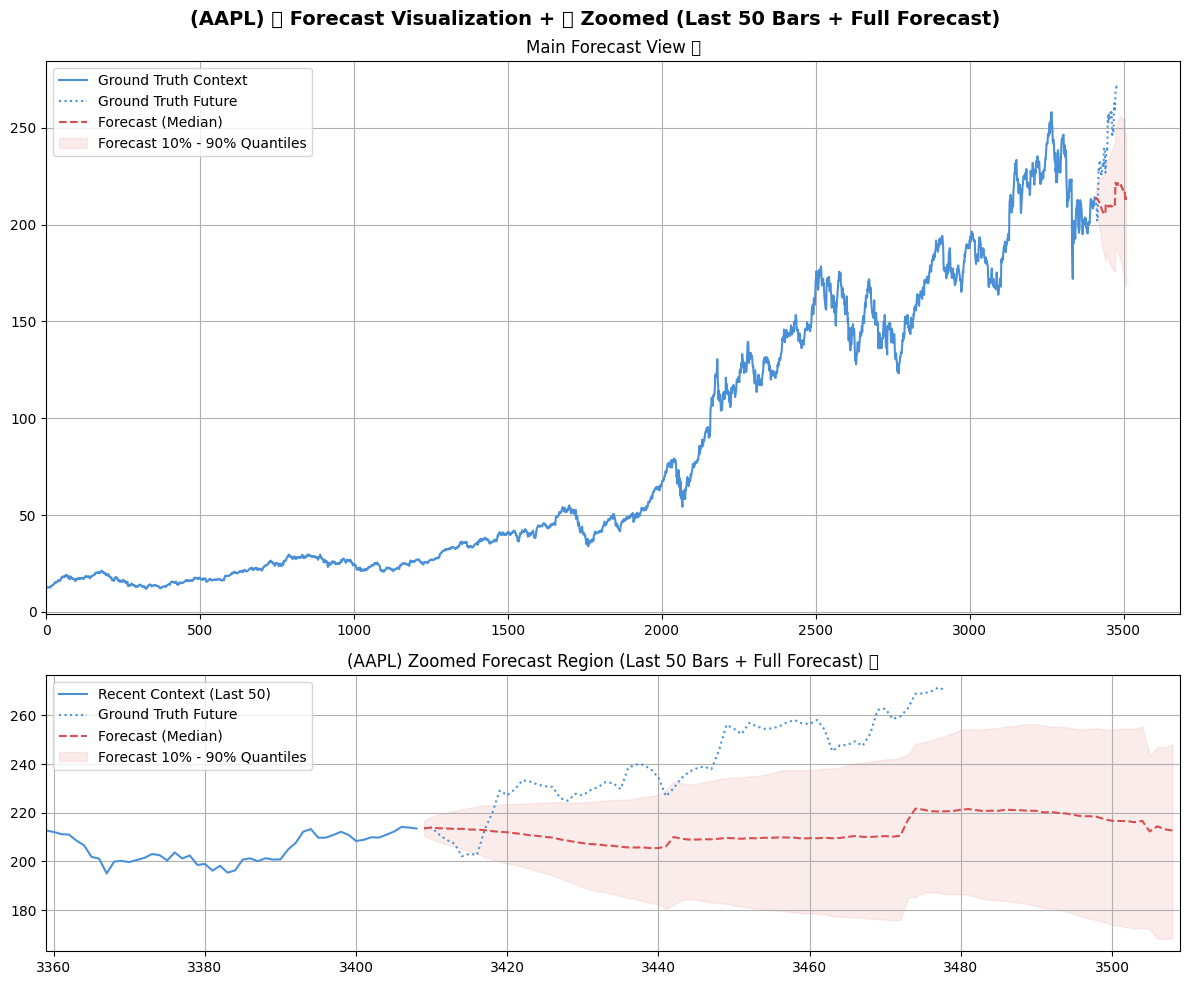

✅ Plotted main and zoomed forecast views (last 50 bars + full forecast) successfully! 🚀
✅ Run completed successfully.

🎉 All stock forecast runs concluded.

🎉 All N-input forecast sweeps completed for AAPL.


In [71]:
all_n_forecasts('AAPL')

# GOOGLE

🔥 Starting all N-input forecast experiments for Ticker: GOOGL...

✨ Initialized ResNLS Forecaster for GOOGL (2012-01-01 to 2025-12-31).
The deriv setting is  False
📥 Loading data for GOOGL...
Loadded data from yfinance
******************************
Startiing predictions
******************************
The close data is:
[16.53783798 16.60917091 16.37877274 16.1553421  15.47037601 15.48727703
 15.55736446 15.64882565 15.53325558 15.62248039]
➡️ Non-overlapping forecast: forecast_x starts at 3409


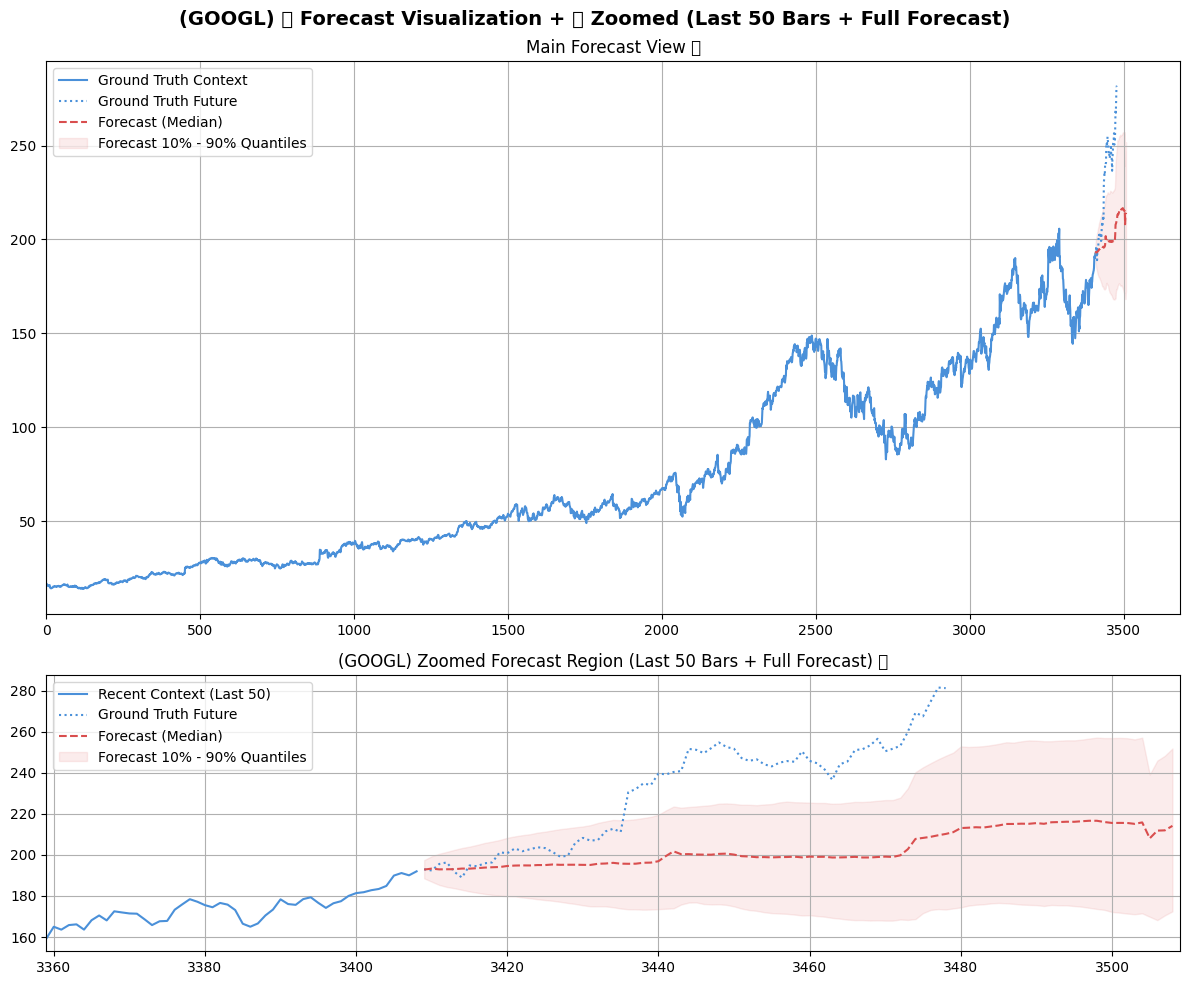

✅ Plotted main and zoomed forecast views (last 50 bars + full forecast) successfully! 🚀
✅ Run completed successfully.

🎉 All stock forecast runs concluded.

🎉 All N-input forecast sweeps completed for GOOGL.


In [72]:
all_n_forecasts('GOOGL')

# AMAZON

🔥 Starting all N-input forecast experiments for Ticker: AMZN...

✨ Initialized ResNLS Forecaster for AMZN (2012-01-01 to 2025-12-31).
The deriv setting is  False
📥 Loading data for AMZN...
Loadded data from yfinance
******************************
Startiing predictions
******************************
The close data is:
[8.95149994 8.87549973 8.88049984 9.13049984 8.92800045 8.96700001
 8.94499969 8.79650021 8.92099953 9.08300018]
➡️ Non-overlapping forecast: forecast_x starts at 3409


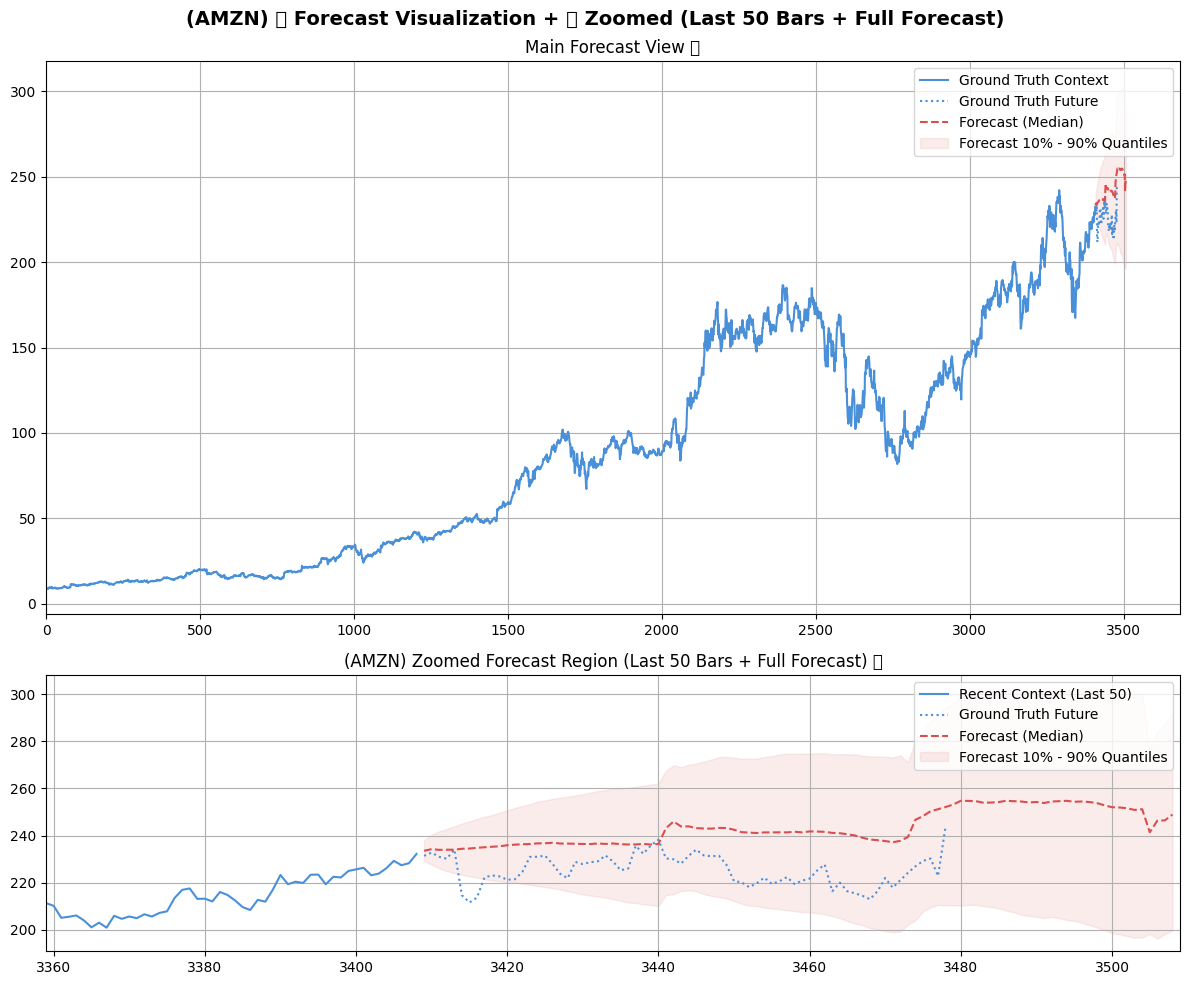

✅ Plotted main and zoomed forecast views (last 50 bars + full forecast) successfully! 🚀
✅ Run completed successfully.

🎉 All stock forecast runs concluded.

🎉 All N-input forecast sweeps completed for AMZN.


In [73]:
all_n_forecasts('AMZN')

# MICROSOFT

🔥 Starting all N-input forecast experiments for Ticker: MSFT...

✨ Initialized ResNLS Forecaster for MSFT (2012-01-01 to 2025-12-31).
The deriv setting is  False
📥 Loading data for MSFT...
Loadded data from yfinance
******************************
Startiing predictions
******************************
The close data is:
[21.00467682 21.49899864 21.71869278 22.05608368 21.76577568 21.84423447
 21.75008202 21.96978378 22.16593742 22.17378235]
➡️ Non-overlapping forecast: forecast_x starts at 3409


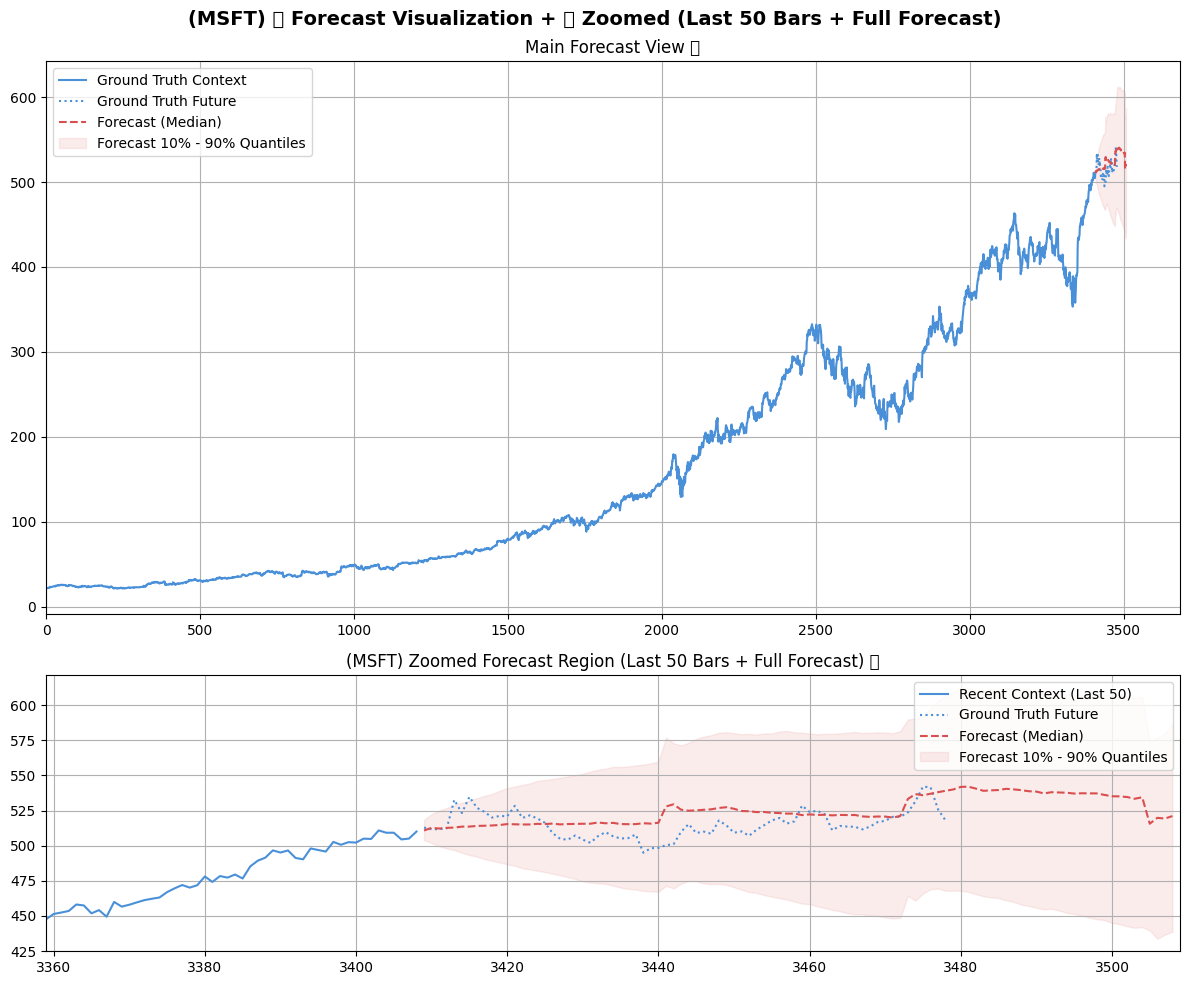

✅ Plotted main and zoomed forecast views (last 50 bars + full forecast) successfully! 🚀
✅ Run completed successfully.

🎉 All stock forecast runs concluded.

🎉 All N-input forecast sweeps completed for MSFT.


In [74]:
all_n_forecasts('MSFT')

# EURUSD

🔥 Starting all N-input forecast experiments for Ticker: EURUSD=X...

✨ Initialized ResNLS Forecaster for EURUSD=X (2012-01-01 to 2025-12-31).
The deriv setting is  False
📥 Loading data for EURUSD=X...
Loadded data from yfinance
******************************
Startiing predictions
******************************
The close data is:
[1.29600823 1.29409635 1.30560231 1.29314244 1.27960682 1.2680378
 1.277596   1.27518487 1.27239406 1.28205132]
➡️ Non-overlapping forecast: forecast_x starts at 3533


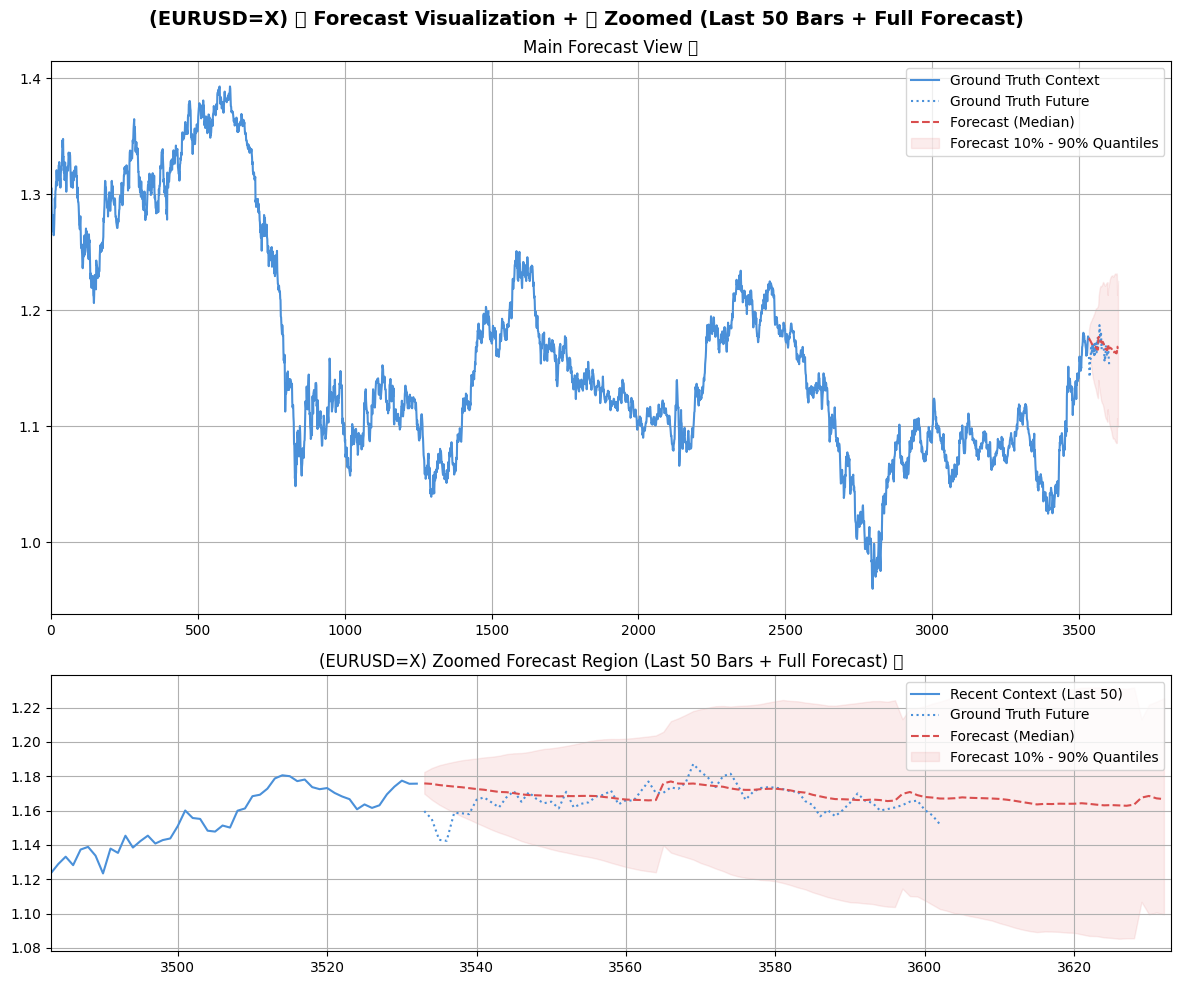

✅ Plotted main and zoomed forecast views (last 50 bars + full forecast) successfully! 🚀
✅ Run completed successfully.

🎉 All stock forecast runs concluded.

🎉 All N-input forecast sweeps completed for EURUSD=X.


In [75]:

TICKER = 'EURUSD=X'
all_n_forecasts(TICKER)

# GBPUSD

🔥 Starting all N-input forecast experiments for Ticker: GBPUSD=X...

✨ Initialized ResNLS Forecaster for GBPUSD=X (2012-01-01 to 2025-12-31).
The deriv setting is  False
📥 Loading data for GBPUSD=X...
Loadded data from yfinance
******************************
Startiing predictions
******************************
The close data is:
[1.55120528 1.55199969 1.56440663 1.56093895 1.55017138 1.54194868
 1.54590559 1.54746056 1.53360128 1.53421295]
➡️ Non-overlapping forecast: forecast_x starts at 3534


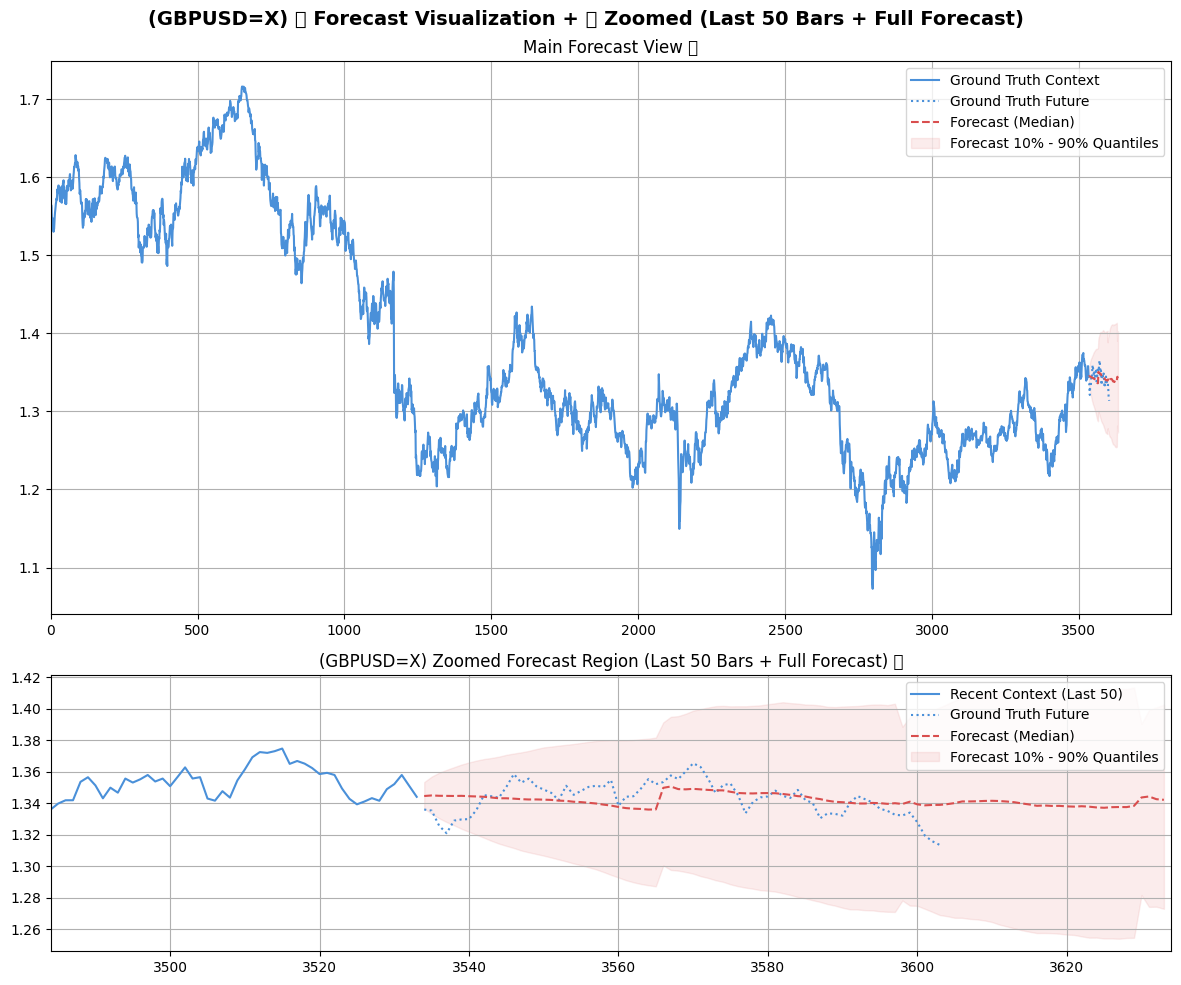

✅ Plotted main and zoomed forecast views (last 50 bars + full forecast) successfully! 🚀
✅ Run completed successfully.

🎉 All stock forecast runs concluded.

🎉 All N-input forecast sweeps completed for GBPUSD=X.


In [76]:
TICKER = 'GBPUSD=X'
all_n_forecasts(TICKER)

# USDJPY

🔥 Starting all N-input forecast experiments for Ticker: USDJPY=X...

✨ Initialized ResNLS Forecaster for USDJPY=X (2012-01-01 to 2025-12-31).
The deriv setting is  False
📥 Loading data for USDJPY=X...
Loadded data from yfinance
******************************
Startiing predictions
******************************
The close data is:
[77.01999664 76.93000031 76.72200012 76.70999908 77.15100098 76.91000366
 76.86000061 76.84999847 76.85800171 76.77899933]
➡️ Non-overlapping forecast: forecast_x starts at 3534


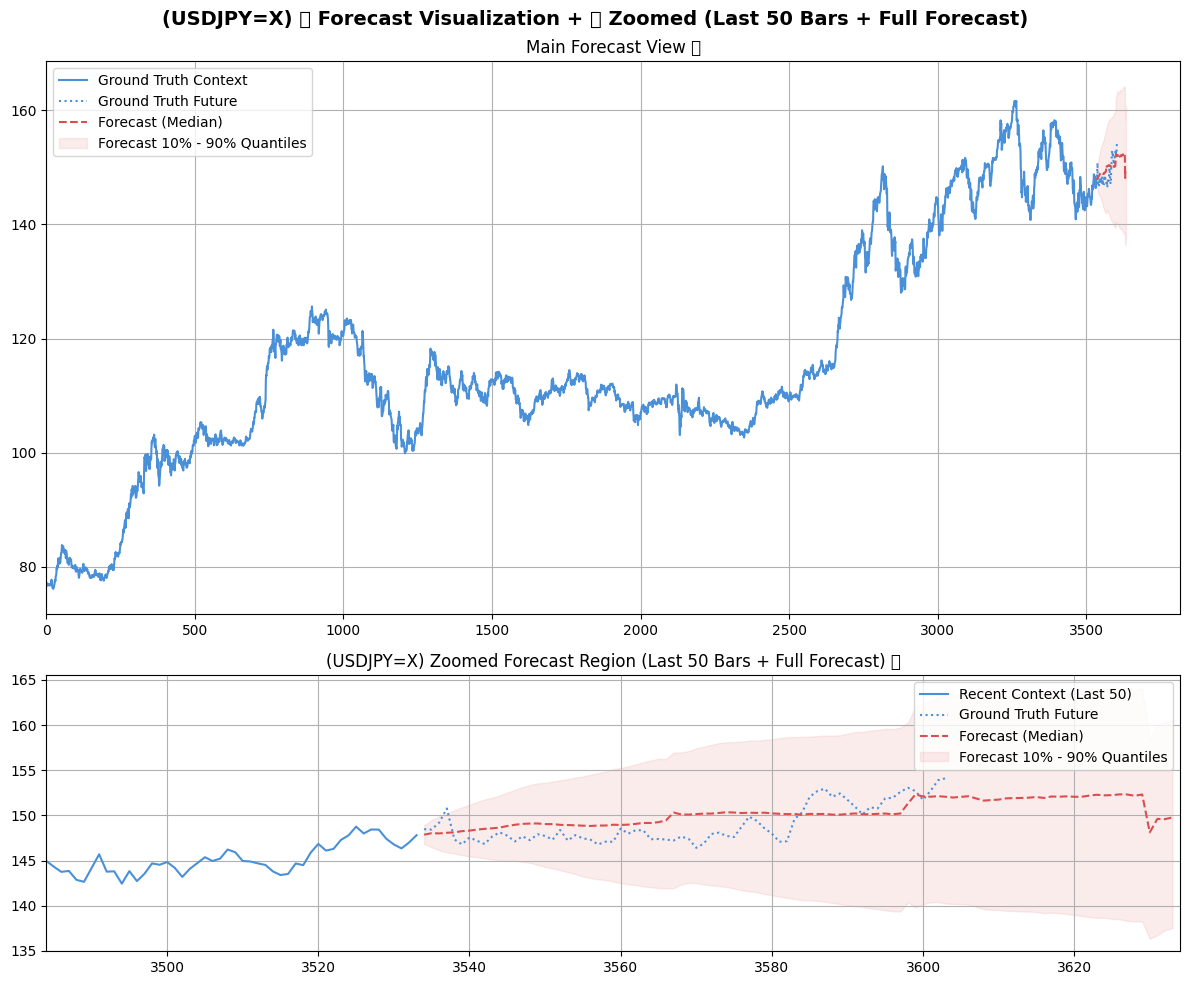

✅ Plotted main and zoomed forecast views (last 50 bars + full forecast) successfully! 🚀
✅ Run completed successfully.

🎉 All stock forecast runs concluded.

🎉 All N-input forecast sweeps completed for USDJPY=X.


In [77]:
TICKER = 'USDJPY=X'
all_n_forecasts(TICKER)

# BTC-USD

🔥 Starting all N-input forecast experiments for Ticker: BTC-USD...

✨ Initialized ResNLS Forecaster for BTC-USD (2012-01-01 to 2025-12-31).
The deriv setting is  False
📥 Loading data for BTC-USD...
Loadded data from yfinance
******************************
Startiing predictions
******************************
The close data is:
[457.33401489 424.44000244 394.79598999 408.9039917  398.8210144
 402.15200806 435.79098511 423.20498657 411.57400513 404.42498779]
➡️ Non-overlapping forecast: forecast_x starts at 3996


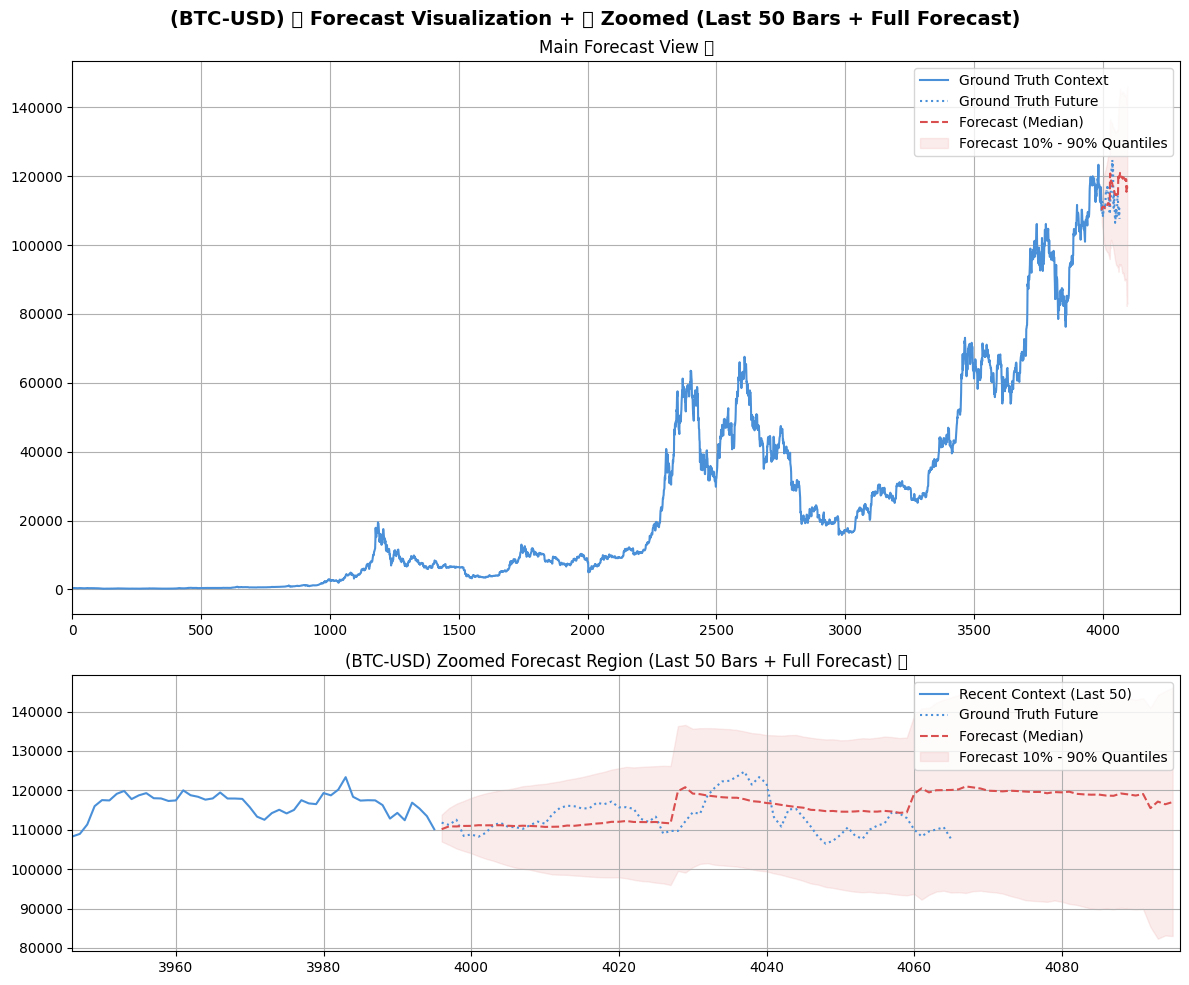

✅ Plotted main and zoomed forecast views (last 50 bars + full forecast) successfully! 🚀
✅ Run completed successfully.

🎉 All stock forecast runs concluded.

🎉 All N-input forecast sweeps completed for BTC-USD.


In [78]:
TICKER = 'BTC-USD'
all_n_forecasts(TICKER)

# ETH USD

🔥 Starting all N-input forecast experiments for Ticker: ETH-USD...

✨ Initialized ResNLS Forecaster for ETH-USD (2012-01-01 to 2025-12-31).
The deriv setting is  False
📥 Loading data for ETH-USD...
Loadded data from yfinance
******************************
Startiing predictions
******************************
The close data is:
[320.88400269 299.25299072 314.68099976 307.9079895  316.71600342
 337.63101196 333.35699463 330.92401123 332.39401245 347.61199951]
➡️ Non-overlapping forecast: forecast_x starts at 2847


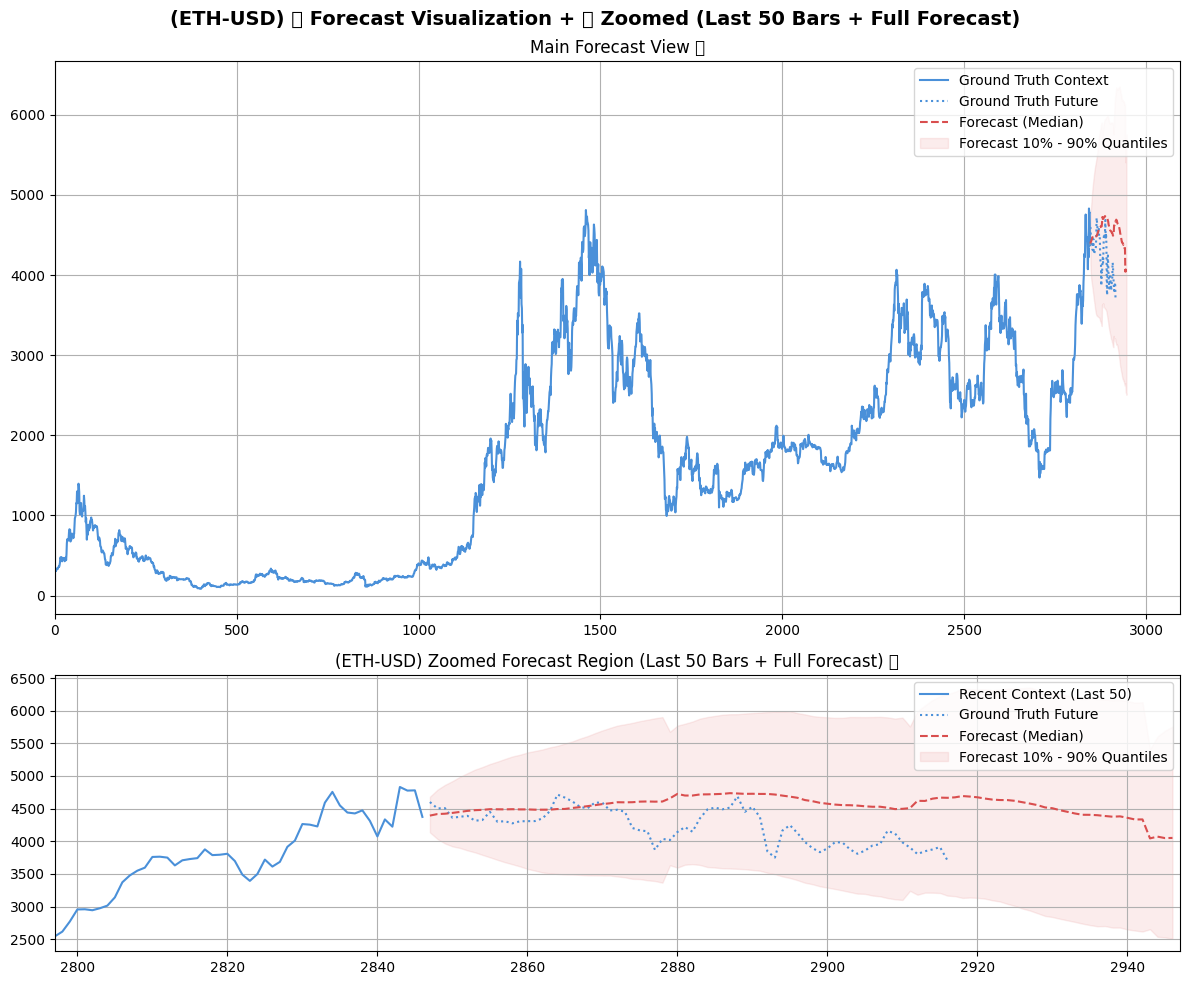

✅ Plotted main and zoomed forecast views (last 50 bars + full forecast) successfully! 🚀
✅ Run completed successfully.

🎉 All stock forecast runs concluded.

🎉 All N-input forecast sweeps completed for ETH-USD.


In [79]:
TICKER = 'ETH-USD'
all_n_forecasts(TICKER)

# SOL USD

🔥 Starting all N-input forecast experiments for Ticker: SOL-USD...

✨ Initialized ResNLS Forecaster for SOL-USD (2012-01-01 to 2025-12-31).
The deriv setting is  False
📥 Loading data for SOL-USD...
Loadded data from yfinance
******************************
Startiing predictions
******************************
The close data is:
[0.95105398 0.77681899 0.88250703 0.77783197 0.66192502 0.64665103
 0.69081599 0.66072798 0.68109602 0.606969  ]
➡️ Non-overlapping forecast: forecast_x starts at 1964


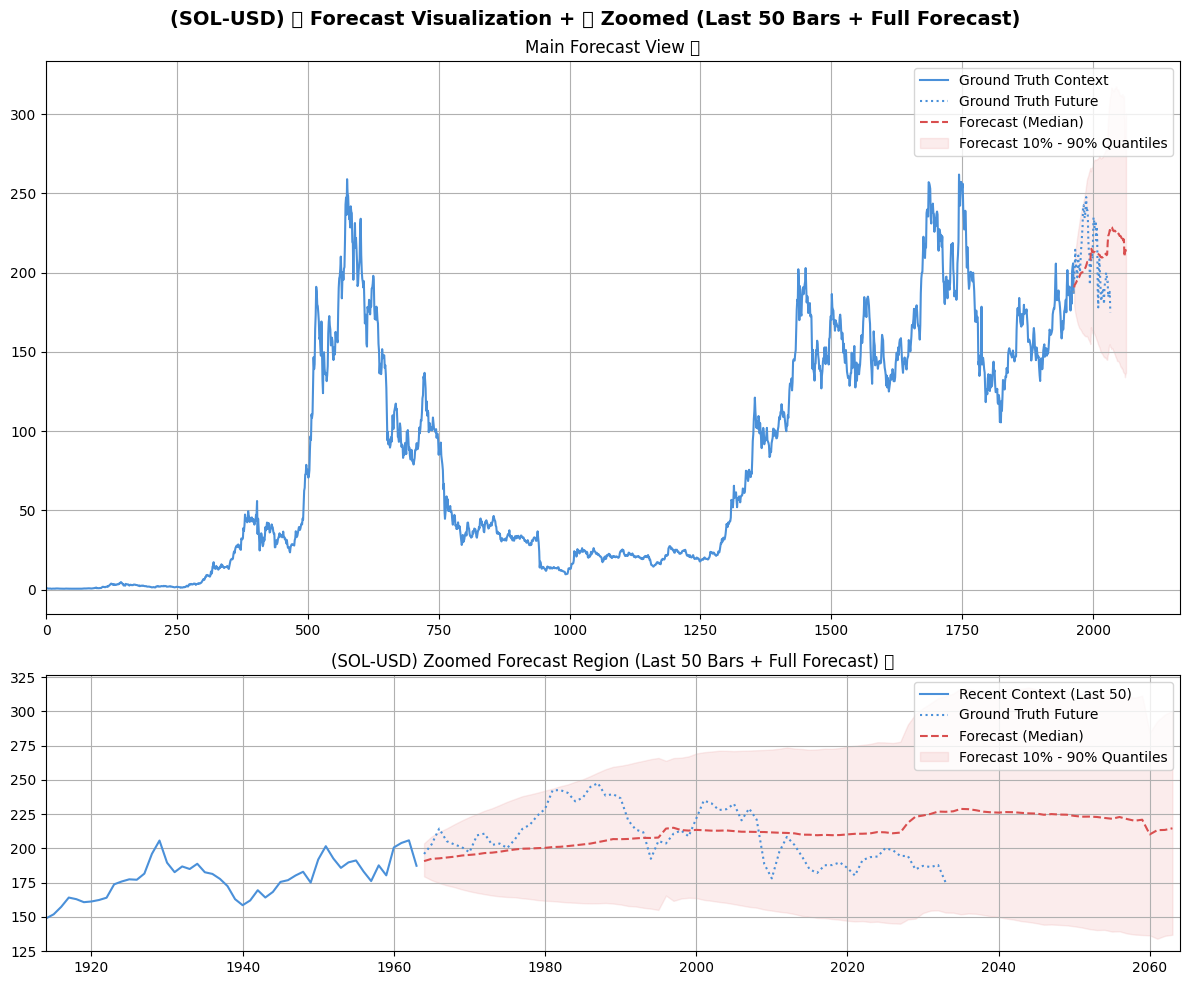

✅ Plotted main and zoomed forecast views (last 50 bars + full forecast) successfully! 🚀
✅ Run completed successfully.

🎉 All stock forecast runs concluded.

🎉 All N-input forecast sweeps completed for SOL-USD.


In [80]:
TICKER = 'SOL-USD'
all_n_forecasts(TICKER)

# Deriv Volatility 10 Index

In [83]:
DERIV_SYMBOL = "R_10"         # 📈 Volatility 100 Index (VIX equivalent)
OHLC_GRANULARITY = 60       # 📅 1 Day in seconds (to mimic daily close data)
OHLC_COUNT = 5000              # 💾 Number of historical daily candles to fetch

# all_n_forecasts(ticker=DERIV_SYMBOL, start_date="2012-01-01", end_date="2025-12-31",threshold_list=[None, 0.001, 0.005, 0.01],deriv=True, count=OHLC_COUNT,tf=OHLC_GRANULARITY)

all_n_forecasts(DERIV_SYMBOL, "2012-01-01", "2025-12-31", 50, 100, 70, True, 5000,60)
      

🔥 Starting all N-input forecast experiments for Ticker: R_10...

✨ Initialized ResNLS Forecaster for R_10 (2012-01-01 to 2025-12-31).
The deriv setting is  True
📥 Fetching 1-minute OHLC data for R_10...
⚠️ Bypassing main thread's running event loop (Kaggle/Jupyter fix). Fetching data in a separate thread...
🔗 Connecting securely to Deriv WebSocket...
💥 Authorization error: The token is invalid.
❌ Error: No data found for R_10. Exiting.
❌ Failed to load deriv data. Exiting.
✅ Run completed successfully.

🎉 All stock forecast runs concluded.

🎉 All N-input forecast sweeps completed for R_10.
